## Importing libraries and modules

In [2]:
import pandas as pd
import numpy as np
import pygmo as pg
import random
import functools
import math as m
import copy
from numpy import genfromtxt

# Geometry modules
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches 
import seaborn as sns

# Misc
import time 
from time import process_time
from scipy.spatial import distance_matrix
from scipy.spatial import ConvexHull
import secrets

# skopt
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV, space, plots
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt import gp_minimize

# sklearn modules
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, recall_score
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 

# For ignoring warnings about bad classifiers - it's the nature of the algorithm to come across these
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Matplotlib configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 80
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## X and y must be declared as numpy matrices

### Loading in data set - other

In [4]:
data_set = 'churn'

In [5]:
X_df = pd.read_csv(f'UCI/{data_set}/X_train.csv')

X_train = pd.read_csv(f'UCI/{data_set}/X_train.csv').values
X_test = pd.read_csv(f'UCI/{data_set}/X_test.csv').values
y_train = genfromtxt(f'UCI/{data_set}/y_train.csv', delimiter=',').astype(int)
y_test = genfromtxt(f'UCI/{data_set}/y_test.csv', delimiter=',').astype(int)

In [6]:
# Declare standard scaler
scaler = StandardScaler()
# Transform training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [7]:
# Random row subsets for running faster (optional)
# rand_index = random.sample(range(X_train.shape[0]),1600)
# X_train = X_train[rand_index,:]
# y_train = y_train[rand_index]

# rand_index = random.sample(range(X_test.shape[0]),400)
# X_test = X_test[rand_index,:]
# y_test = y_test[rand_index]

In [8]:
# Number of features in model
total_features = int(X_train.shape[1])

# Feature names
feat_names = np.asarray(list(X_df.columns))

### Feature Subsets Partitioning - From 11 Feature Selection Methods

In [9]:
# Defining the best features, as chosen by a variety of filter and wrapper methods
best_features = genfromtxt(f'UCI/{data_set}/best.csv', delimiter=',').astype(int)

# Defining features that are not as good as the best, but still good
good_features = genfromtxt(f'UCI/{data_set}/good.csv', delimiter=',').astype(int)

# Defining features that are not as good as the best, but still good
worst_features = genfromtxt(f'UCI/{data_set}/worst.csv', delimiter=',').astype(int)

# Make all combinations of unions
bg_features = list(set(list(best_features)).union(set(list(good_features))))

bw_features = list(set(list(best_features)).union(set(list(worst_features))))

gw_features = list(set(list(good_features)).union(set(list(worst_features))))

all_features = np.asarray(list(range(total_features)))

print(f"There are {len(best_features)} best features, {len(good_features)} good features and {len(worst_features)} worst features")

There are 17 best features, 17 good features and 17 worst features


### Learning algorithms

In [10]:
# Set of learning algorithms
model_dict = {
    "SVC lin": SVC(random_state=42,kernel='linear',max_iter=int(1e4), probability=True),
    "Log lasso": LogisticRegression(solver='liblinear',random_state=42,penalty='l1'),
    "Log ridge": LogisticRegression(random_state=42,penalty='l2'),
    "Gauss NB": GaussianNB(), # Naive Bayes
    "Dec trees": DecisionTreeClassifier(random_state=42),
    "Grad boost": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
}

In [11]:
def get_model_time(model_string):
    '''
    Returns the seconds of how long a classifier takes to fit the whole data matrix
    '''
    
    pipeline = Pipeline([
#         ("scaler", StandardScaler()),
        ("model", model_dict[model_string])
    ])
    
    times = []
    
    # Times are inconsistent - get max by looping through several times
    for _ in range(100):
    
        start = process_time()
        pipeline.fit(X_train, y_train)
        end = process_time()
        
        times.append(end-start)
    
    return np.mean(times)

### Declaring results from the paper and other MOEAs for comparative plots, for this given data set

In [12]:
# Loading in the relevant results to compare against from the HFMOEA paper
hfmoea_results = {
    "breastcancer": np.asarray([[4,0.93],[5,0.982],[11,0.994]]),
    "congress": np.asarray([3,1]),
    "heart": np.asarray([[3,0.65],[4,0.925],[6,0.945]]),
    "ionosphere": np.asarray([[2,0.98],[12,0.99]]),
    "sonar": np.asarray([17,1]),
    "tictactoe": np.asarray([[2,0.66],[4,0.84]]),
}

# Initial Population

### Initialise fully random population of features

In [13]:
def initialise_rand_pop(pop_size):
    '''
    I: population size (int)
    O: random population of size pop_size
    '''
    
    # Initialise empty array
    initial_pop = []
    
    for i in range(pop_size):
        
        # Generate a random individual, add it to array
        chrom = np.random.randint(0,2,total_features)

        initial_pop.append(chrom)
        
    return np.asarray(initial_pop).astype(int)

### Make a seeded initial population

In [14]:
def make_initial_pop(pop_size, truly_random=False):
    '''
    I: population size (int)
    I (optional): if True, uses initialise_rand_pop
    O: seeded population of size pop_size from seven subsets
    '''
    
    if truly_random:
        return initialise_rand_pop(pop_size)
    
    pop = []

    # Declare all valid feature sets to draw from
    feat_sets = [all_features, bg_features, bw_features, gw_features, best_features, good_features, worst_features]
    
    for _ in range(pop_size):
            
        # Make a chromosome of zeros
        chrom = np.zeros((total_features,)).astype(int)
        
        # Choose a feature set at random
        cat = np.random.randint(0,len(feat_sets))

        # Only features in the given feature set are randomized, rest of the indices remain as zero
        chrom[feat_sets[cat]] = np.random.randint(0,2,len(feat_sets[cat]))

        # Ensure you never get all zeros in chromosome
        while len(np.unique(chrom)) == 1:

            chrom[feat_sets[cat]] = np.random.randint(0,2,len(feat_sets[cat]))
            
        pop.append(chrom)
    
    return np.asarray(pop)

### Normalize costs

In [15]:
def normalise(value):
    '''
    I: an evaluation value
    O: its normalised value 
    '''

    # The worst possible scenario is using all features (max comp time) 
    nadir = comp_time_all_X
    # The best possible scenario is a negligible time
    ideal = 1e-8
                    
    return ((value - ideal) / (nadir - ideal))

def normalise(value):
    return value

# Hyperparameters, evaluation, non-dom rank, crowding

### Scoring

In [16]:
def MatthewsCorrelation(confmat):
    '''
    Calculates the Matthews Correlation coefficient based on confusion matrix elements.
    '''
    # Ignore NaN warnings
    np.seterr(divide='ignore', invalid='ignore')
    
    # Decompose confusion mattrix elements
    [[tn, fp],[fn, tp]] = confmat
    
    # Calculate Matthew's Correlation Coefficient
    mc_coef = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    
    # Catch NaNs, return them as zero
    if np.isnan(mc_coef):
        return 0
    
    return mc_coef

In [17]:
def get_scores(predictor, pipeline, feature_indices):
    '''
    Returns seven scoring metrics for a given predictor
    '''
    
    # For getting ROC AUC score
    y_pred = pipeline.predict_proba(X_test[:,feature_indices])[:, 1]
    AUC_score = roc_auc_score(y_test, y_pred)
              
    dictionary = {"Classification Accuracy": accuracy_score(y_test, predictor),
                  "Specificity": recall_score(y_test, predictor, pos_label =0),
                  "Recall": recall_score(y_test, predictor),
                  "Precision": precision_score(y_test, predictor, zero_division=0.0),
                  "F1 Score": f1_score(y_test, predictor, zero_division=0.0),
                  "ROC AUC": AUC_score,
                  "Matt Corr": MatthewsCorrelation(confusion_matrix(y_true=y_test, y_pred=predictor)),
                  "Num Features": int(len(feature_indices)) }
    
    return dictionary

In [18]:
def get_scores_for_pop(chrom):
    '''
    A dictionary of all pops and their scores is kept, 
    this is used to retrieve the scores given the chromosome
    '''
    
    return pop_scores_dict[chrom.tobytes()]

### Evaluate objective functions

In [19]:
def evaluation(pop):
    '''
    I: a population, ndarray with chromosomes in each row
    O: matrix with normalized objective values of time and classifier score, as well as the chromosome in the same row
    '''
    # Empty matrix for writing in fitness 
    # 3 columns for storing results
    fitness_values = np.zeros((pop.shape[0], 3 + total_features)) 
    
    pipeline = model_dict[NSGA_model]
    
    # Loop over each chromosome, write into empty fitness matrix
    for i, chromosome in enumerate(pop):
        
        while len(np.unique(chromosome)) == 1:
            pop[i] = initialise_rand_pop(1)
        
        # Get indices of all the ones in the chromosome
        feature_indices = np.where(chromosome == 1)[0].tolist()
 
        # Objective 1 - validation accuracy for given chromosome

        # Store the chromosome
        fitness_values[i,3:] = copy.deepcopy(chromosome)
        
        # Fit the classifier on training dataset and generate predictions for test dataset
        start = process_time()
        model = pipeline.fit(X_train[:,feature_indices],y_train)
        end = process_time()
        
        # Objective 2 - comp. time for given chromosome
        if objective2 == 'time':
            fitness_values[i,1] = normalise(end-start)
    
        # Objective 2 - number of features used
        if objective2 == 'num_features':
            fitness_values[i,1] = len(np.where(chromosome == 1)[0])
    
        # Put given score as objective one, store all scores in dict associated with chromosome
        y_pred = model.predict(X_test[:,feature_indices])
        
        scores = get_scores(y_pred, model, feature_indices)
        
        # Discourage low feature cardinalities as good solutions
        if scores['Num Features'] < constraint_features:
            fitness_values[i,1] += penalty
        
        if scoring_metric == 'Mixed':
            score = (scores['F1 Score'] + scores['Recall'] + scores['Matt Corr'])/3
            
        else:
            score = float(scores[scoring_metric])
        
        # Make some scores infeasible as Pareto solutions
        if scores['Recall'] == 0 or scores['Matt Corr'] < 0.2:
            fitness_values[i,1] = fitness_values[i,1] + 1
        
        else:
            fitness_values[i,0] = score
            
        # Store all scores for this given individual
        pop_scores_dict[chromosome.astype(int).tobytes()] = scores

        # objective 1 - but for minimization 
        fitness_values[i,2] = (1-fitness_values[i,0])
            
    return fitness_values

## Getting and plotting non-dominated objective values for a set of random feas. solutions 

In [20]:
def plot_initpop(data, show_or_save, lims=True):
    '''
    Input: output of evaluation function for a given population
    Output: visualise all individuals in objective space, labelled by their initialisation origin
    
    '''
    plt.scatter(data[:,0], data[:,1], c='chocolate', s=25 ,marker="x", label='All Seven Feature Subsets')

    if lims:
        plt.xlim(set_xlim[0],set_xlim[1])
        plt.ylim(set_ylim[0],set_ylim[1])
    
#     if scoring_metric == 'Mixed':
#         plt.xlabel('Avg. MC, Recall and F1 Scores')
        
#     else:
#         plt.xlabel(scoring_metric)   
        
#     plt.ylabel("Normalised Comp. Time")
    
    plt.ylabel(y_axis_label)
    plt.xlabel(scoring_metric)
    
    plt.legend(loc='upper left')
    
    if show_or_save == 0:
        
        plt.savefig(f"init_pop.pdf", bbox_inches='tight', format="pdf", dpi=1200)
        plt.clf()
        
    if show_or_save == 1:

        plt.show()

## Getting every non-dominated front in a given population, and the crowding distances for these fronts - using pygmo

In [21]:
def get_all_fronts(data, pop):
    '''
    Input: output of evaluation function (N * 3) where N is population size
    Output: array of all non-dominated fronts in the population
            array of indices of the constituent individuals of these fronts
            in the population
            
            both of these are ordered in DESCENDING order by VALIDATION
            ACCURACY
    
    ndf - array of the indices of non-dominated fronts
          indices refer to the position of the point in the chromosome
    dl - domination list
    dc - domination count
    ndr - non-domination rank
    '''
    
    # Initalise empty list of fronts 
    fronts = []
    indices_ordered = []
    
    # Get only minimization objective values (second and third column),
    # then run fast non-dominated sorting algorithm
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(data[:,[1,2]])
    
    for i,front_indices in enumerate(ndf):
        
        # Extract rows from evaluation function output, corr to indices 
        # of the non-dominated fronts 
        front = data[ndf[i]]
        
        reshaped_index = np.reshape(ndf[i],
                                   (front.shape[0],1))
        
        front = np.hstack((front,reshaped_index))
                          
        # Put rows in order for each front, best first by accuracy
        # This also orders the indices
        front = front[front[:, 0].argsort()[::-1]]
        
        # Store indices column as ints
        index = front[:,-1].astype(int)
        
        # Separate indices column from rest of data
        front = front[:,:-1]

        # Append to fronts and indices list
        fronts.append(front)
        indices_ordered.append(index)
    
    return fronts, indices_ordered

In [22]:
def get_crowding_distances(fronts):
    '''
    Input: fronts from get_all_fronts
    Output: array of arrays of crowding distances for each front in fronts input
            all np.inf instances (boundaries of a given front) are replaced with
            the maximum crowding in the whole array of arrays that isn't np.inf
    '''
    
    crowd_distances = []
    
    for i,front in enumerate(fronts):
        
        # Handle singleton fronts
        if len(front)==1:
            crowd_distances.append(np.asarray([np.inf]))
        
        # Get crowding distances for the two objectives we want:
        # validation accuracy and cost
        else:
            distances = pg.crowding_distance(fronts[i][:,:2])

            crowd_distances.append(distances)
        
    # This replaces all np.inf with the next highest element that is not np.inf
    # Flatten crowding 2D array
    crowding_flat = [item for sub_list in crowd_distances for item in sub_list]

    # Make a list with no np.inf values, take its maximum
    max_dist = max([el for el in crowding_flat if el != np.inf]) 

    # Replace all np.inf in original array with maximum element
    for i,front in enumerate(crowd_distances):
        crowd_distances[i] = np.where(front == np.inf, max_dist, front)
        
    return crowd_distances

## Non-dominated comparison - functions for next generation of the population

In [23]:
def fronts_to_nondomination_rank(fronts_indices, pop_size):
    '''
    Input: second output of get_crowding_distances function
    Output: a dictionary that ranks all fronts, the elements of each front
    in the fronts array are assigned a numerical ranking
    
    E.g. all indices (which correspond to chromosomes in the population)
    get assigned a zero in the dictionary
    '''
    
    # Declare empty dictionary
    nondomination_rank_dict = {}
    
    # Loop through all fronts, associate a rank (simply the index of the given front 
    # in the array of all fronts)
    for i,front in enumerate(fronts_indices):
        for x in front:   
            nondomination_rank_dict[x] = i
            
    # Give an infinititely bad rank for indices that are not part of a front
    indices_flatten = [item for sub_list in fronts_indices for item in sub_list]
    
    not_in_fronts = list(set(list(range(pop_size))) - set(indices_flatten))

    for index in not_in_fronts:
        nondomination_rank_dict[index] = np.inf
    
    return nondomination_rank_dict

In [24]:
def crowding_dictionary(fronts_indices, crowding, pop_size):
    '''
    Input: second output of get_crowding_distances function
    Output: a dictionary that associates a crowding distance with 
           index of the population
    '''
    
    crowding_dict = {}
    
    for i,front in enumerate(fronts_indices):
        for j,x in enumerate(front):   
            crowding_dict[x] = crowding[i][j]
            
    # Give an infinitely low crowding cost for indices that are not part of a front
    indices_flatten = [item for sub_list in fronts_indices for item in sub_list]

    not_in_fronts = list(set(list(range(pop_size))) - set(indices_flatten))

    for index in not_in_fronts:
        crowding_dict[index] = -(np.inf)
            
    return crowding_dict
    

In [25]:
def nondominated_sort(fronts_indices, crowding_metrics, pop_size):
    '''
    Input: second output of get_all_fronts distances, output of get_crowding_distances
           pop-size param (int) entered when population initialized
           
    This function depends on and calls both the fronts_to_nondomination_rank and the
    crowding_dictionary functions
        
    Output: all solutions sorted by nondomination rank
    '''
    
    # Make a list of all indices in the population
    # Each index refers to a population chromosome
    indices = list(range(pop_size))
    
    # Call the relevant functions to get the dictionaries for ranking
    
    nondomination_rank_dict = fronts_to_nondomination_rank(fronts_indices, pop_size)
    
    crowding_dict = crowding_dictionary(fronts_indices, crowding_metrics, pop_size)

    def nondominated_compare(a,b):
        
        '''
        returns 1 if a dominates b, or if they equal, but a is less crowded
        return -1 if b dominates a, or if they equal, but b is less crowded
        returns 0 if they are equal in every sense
        
        functools then sorts the array according to these rules, with the best soln at index 0
        '''
        
        # Smaller domination rank is better
        if nondomination_rank_dict[a] > nondomination_rank_dict[b]:  
            return -1
        elif nondomination_rank_dict[a] < nondomination_rank_dict[b]:
            return 1
        
        # Larger crowding metric is better
        else:
            if crowding_dict[a] < crowding_dict[b]:   # crowding metrics, larger better
                return -1
            elif crowding_dict[a] > crowding_dict[b]:
                return 1
            else:
                return 0
            
    # Map function over indices, decreasing order: the best is the first
    non_dominated_sorted_indices = sorted(indices,key = functools.cmp_to_key(nondominated_compare),reverse=True) 
    return np.asarray(non_dominated_sorted_indices)

In [26]:
def sort_by_crowding_only(fronts_indices, crowding_metrics):
    '''
    I: array of population indices sorted by front, array of crowding metrics for each chromosome
    O: array of population sorted by crowding metric
    '''
    
    # Flatten both input arrays
    indices_flatten = [item for sub_list in fronts_indices for item in sub_list]
    metrics_flatten = [item for sub_list in crowding_metrics for item in sub_list]
    
    # Matrix of zeros for storing index of chromosome in pop in first column
    # its crowding metric in the second
    M = np.zeros((len(indices_flatten),2))
    
    # Write flattened arrays into columns of empty matrix
    M[:,0] = indices_flatten
    M[:,1] = metrics_flatten
    
    # Sort by descending crowding metrics, highest first
    sorted_by_crowding = M[M[:, 1].argsort()[::-1]]
    
    return sorted_by_crowding[:,0].astype(int)

## Operators

### Tournament selection from two lists: nondomination rank and crowding rank

In [27]:
def tournament_selection(num_parents,num_offspring):
    '''
    Input: two ints, number of parents and desired number of offspring
    Generate 2 random numbers, take the smaller (parent list is already sorted, 
    smaller index is better)
    Keep only the smaller one, append to a list
    '''
    reproducing_individual_indices = []
    for _ in range(num_offspring):
        
        # Take two random indices that correspond to the output array of nondominated_sort
        contestants = np.random.randint(0,num_parents,2)
        
        # Take the minimum of these indices, as the lower the index is the fitter the individual
        winner = np.min(contestants)
        
        # Append onto offspring array
        reproducing_individual_indices.append(winner)
            
    return reproducing_individual_indices

In [28]:
def tournament_lambda(lambda_param, num_offspring, sorted_nondom, sorted_crowding, pop):   
    '''
    Tournament selection - pop_size*lambda_param chromosomes drawn from list of chromosomes sorted by nondom rank
    pop_size*(1-lambda_param) chromosomes drawn from list of chromosomes sorted by crowding distance
    
    Intention is to balance exploration and exploitation
    '''
    
    # Number of individuals that will be drawn from nondominated sort list
    num_ndsort = int(m.ceil(lambda_param*num_offspring))
    offspring_ndsort_indices = sorted_nondom[tournament_selection(len(sorted_nondom), num_ndsort)].tolist()
    
    offspring_ndsort = pop[offspring_ndsort_indices]
        
    # To avoid duplicates, delete elements from offspring_ndsort in crowding list
    for el,i in enumerate(offspring_ndsort):
        
        index_in_crowding = np.where(sorted_crowding == el)[0][0]
        
        sorted_crowding = np.delete(sorted_crowding,index_in_crowding)

    # Number of individuals that will be drawn from crowding list
    num_crowding = int(m.floor((1-lambda_param)*num_offspring))
    offspring_crowding = sorted_crowding[tournament_selection(len(sorted_crowding), num_crowding)].tolist()
    
    offspring_crowding = pop[offspring_crowding]
    
    offspring = np.vstack((offspring_ndsort,offspring_crowding))
    
    return offspring
    

### Crossover operator

In [29]:
def k_point_crossover(parent1, parent2, k):
    """
    Perform k-point crossover on two parent numpy arrays to produce two children.

    Parameters:
        parent1 (numpy.ndarray): First parent array.
        parent2 (numpy.ndarray): Second parent array.
        k (int): Number of crossover points.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Two children arrays produced by crossover.
    """

    # Generate k unique crossover points
    crossover_points = sorted(np.random.choice(len(parent1), k, replace=False))

    # Initialize child arrays
    child1 = np.zeros_like(parent1)
    child2 = np.zeros_like(parent2)

    # Perform k-point crossover
    start_idx = 0
    for point in crossover_points:
        end_idx = point + 1
        if (point + 1) % 2 == 0:
            child1[start_idx:end_idx] = parent1[start_idx:end_idx]
            child2[start_idx:end_idx] = parent2[start_idx:end_idx]
        else:
            child1[start_idx:end_idx] = parent2[start_idx:end_idx]
            child2[start_idx:end_idx] = parent1[start_idx:end_idx]
        start_idx = end_idx

    # Copy the remaining segment after the last crossover point
    child1[start_idx:] = parent1[start_idx:]
    child2[start_idx:] = parent2[start_idx:]

    return child1, child2


In [30]:
def crossover(crossover_param, cross_k_param, offspring):
    '''
    Input: a crossover parameter (float, range zero to one), output of tournament_selection,
    feature_cardinality (int), surviving_individuals (top half of the array from nondominated_sort)
    
    Output: ndarray of crossed over
    '''
    
    # Desired number of crossed over individuals, based on parameter
    num_crossed = int(m.ceil(crossover_param*len(offspring)))
        
    # Check if this number is even, there must be an even number of individuals for crossover
    if (num_crossed % 2) != 0:
        num_crossed-=1
        
    # Declare empty list for crossed individuals
    crossed_offspring = []
    
    # Choose num_crossed amount of random indices
    indices_for_crossover = random.sample(range(len(offspring)),num_crossed) 
    
    # Reshape this array to allow looping through it
    indices_for_crossover_ = np.reshape(indices_for_crossover,(int(num_crossed/2),2))
    
    # Main loop
    for index_pair in indices_for_crossover_:
        
        parent1, parent2 = offspring[index_pair[0]], offspring[index_pair[1]]
        
        # Define a random single cutting point
        cut = np.random.randint(1,total_features)
        
        # Crossover mechanism
        crossed_1, crossed_2 = k_point_crossover(parent1, parent2, cross_k_param)
        
        # Append crossed individuals to array
        crossed_offspring.append(crossed_1)
        crossed_offspring.append(crossed_2)
    
    # Rewrite the original individuals with crossed over individuals, rest are unchanged
    offspring[indices_for_crossover] = crossed_offspring
    
    return offspring

### Mutation operator

In [31]:
def mutation(offspring,num_mutation_sites):
    '''
    Input: output of crossed_offspring, desired number of mutation sites (int), 
           total_features (int)
    Output: ndarray of mutated offspring
    '''
    
    # Catch errors
    if total_features < int(num_mutation_sites):
        return print("Mutation site number cannot exceed length of array of individual")
    
    for i,ind in enumerate(offspring.copy()):
        
        # Get random mutation sites for this individual, based on num_mutation_sites param
        mutation_sites = random.sample(range(total_features),int(num_mutation_sites))
        
        # Flip the bits at these sites
        for j, index in enumerate(mutation_sites):
            
            if ind[index]==0:
                offspring[i][index]=1
            else:
                offspring[i][index]=0
    
    # Return the mutated offspring
    return offspring

## Neighbourhood search

In [32]:
def ns_operator(feature_set, localsearch_param, best_front_chrom):
    '''
    Bit flip operator for local neighbourhood search
    I: feature_set in which bits are flipped, 
       localsearch_param - int of how many unique locations
       best_front_chrom - incumbent top six non-dominated values
       
    O: Chromosomes with bits flipped at localsearch_param number of 
    unique indices for each chromosome in best_front_chrom, indices
    can only be within feature_set
    '''
    
    output = []
    
    for chrom in best_front_chrom:        
        
        # Make a localsearch_param amount of copies of each chromosome in best_front_chrom
        temp = np.tile(np.asarray(copy.deepcopy(chrom)),(localsearch_param,1))
        
        # Get UNIQUE random indices depending on the given feature_set
        rand_index = random.sample(list(feature_set),localsearch_param)
        
        # Flip bits at the unique random indices
        for i in range(localsearch_param):
        
            if temp[i][rand_index[i]]==0:
                temp[i][rand_index[i]]=1
            if temp[i][rand_index[i]]==1:
                temp[i][rand_index[i]]=0
                
            # If there are clones, try 150 times to fix this, prevent infinite loops
            counter = 0
            while np.array_equal(temp[i], chrom):
                
                rand_index_ = random.sample(list(feature_set),localsearch_param)
                
                if temp[i][rand_index_[i]]==0:
                    temp[i][rand_index_[i]]=1
                if temp[i][rand_index_[i]]==1:
                    temp[i][rand_index_[i]]=0
                    
                counter += 1
                
                if counter > 150:
                    break
                
            output.append(copy.deepcopy(temp[i]))
            
    return np.asarray(output)

In [33]:
def best_PF_sofar(fronts_all_iter, front_points, elitism):
    '''
    Returns the top front_points number of incumbent non-dominated members of the population
    Used for local search
    '''
    
    # Count how many points there are in the list of the best fronts from every iteration so far
    points_ = points_in_list(fronts_all_iter)
    
    # Stop errors from an initial population that has a best front with less than front_points points
    if points_ < front_points:
        front_points = points_
    
    # Create a matrix to write all these points into
    matrix = np.zeros((points_,total_features+3))
    
    c=0
    for front in fronts_all_iter:

        for point in front:

            matrix[c,:] = copy.deepcopy(point)

            c+=1
        
    # Run non-dom sorting on the whole matrix
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(matrix[:,[1,2]])
    
    # Flatten output list of non-dominated fronts 
    ndf_flat = np.asarray([item for sub_list in ndf for item in sub_list])
    
    if elitism:
    
        # Take a front_points amount of points from the top of this list, return their respective chromosomes
        best_n = matrix[ndf_flat[:front_points]]

        best_n_pops = []

        for el in best_n:

            best_n_pops.append(el[3:].astype(int))

        return np.asarray(best_n_pops)
    
    else: 
        # Choose chromosomes using tournament selection
        
        indices = tournament_selection(num_parents=len(ndf_flat),num_offspring=front_points)
        
        tourn_chosen = matrix[ndf_flat[indices]]

        pops = []

        for el in tourn_chosen:

            pops.append(el[3:].astype(int))

        return np.asarray(pops)

In [34]:
def points_in_list(fronts_all_iter):
    '''
    Returns how many individual points in are in all the Pareto Fronts in fronts_all_iter, allowing deconstruction
    '''
    
    count = 0
    
    for front in fronts_all_iter:
        
        count += front.shape[0]
        
    return count

In [35]:
def neighbourhood_search(fronts_all_iter, localsearch_param, front_points=6):

    '''
    I: output of get_all_fronts (fronts and fronts_indices),
    front_points: an integer, fxn takes a front_points amount of NON-EDGE points in the fronts.
    e.g. for a front_points value of 5:
         if there are 7 points in the first front, the 5 in the center are taken
         if there are 4 points in the first front, two center ones are taken and three points from
         the front behind it (fronts[1]) are then taken, for a total of five points
        
    localsearch_param: for each point in the front, this integer value controls how many UNIQUE 
    indices are flipped (1 to 0, or 0 to 1)
    
    pop: the current population (for this iteration and run), used to retrieve the chromosomes
    
    O: an array of chromosomes of new solutions within the neighbourhood of the best two fronts
    '''
        
    # Random chance between elitism or exploration
    if elitism_param == 0:
        elitism = np.random.randint(0,2)
        
    if elitism_param == 1:
        elitism = 1
    
    # Use the indices to fetch the top (default six) chromosomes in the population by nd-rank
    best_front_chrom = best_PF_sofar(fronts_all_iter, front_points, elitism)
    
    # Make a list off all the different feature index subsets you have
    feature_subsets = [best_features, worst_features, good_features, best_features]
    
    neighbourhood = []
    
    # Perform a search using all different subsets
    for j,subset in enumerate(feature_subsets):
        
        neighbourhood.append(ns_operator(subset, localsearch_param, best_front_chrom))
        
    # Reshape into standard population output
    output = np.asarray([item for sub_list in neighbourhood for item in sub_list])
            
    return output

In [36]:
def get_neighbourhood(polygon_selection, localsearch_param, pop, fronts, fronts_indices):
    '''
    Runs all local search functions
    '''
    
    # If exploitative search isn't on, do neighbourhood search as normal
    if polygon_selection == 0:
        
        neighbourhood = neighbourhood_search(fronts_all_iter, localsearch_param)
        
        # Get at least 10 points from local search - due to random sampling can get small numbers or singletons
        # This is a cheap while loop - it is just array manipulations, no ML training takes place
        while len(neighbourhood) < 10:
            neighbourhood = neighbourhood_search(fronts_all_iter, localsearch_param)
            
        return neighbourhood
    
    # Use more expensive polygon selection for the last few iterations
    if polygon_selection == 1:
        
        neigh_before = neighbourhood_search(fronts_all_iter, localsearch_param=exploit_param, front_points=10)
        
        # Get objective values of the chromosomes from neighbourhood search
        neigh_before_ev = evaluation(neigh_before)

        # Accept only the solutions close to the front
        neigh_after_ev, neigh_after = points_inside_area(fronts, neigh_before_ev)
        
        # Must have more than one solution accepted for crossover and mutation
        if len(neigh_after) > 1:
        
            # Do crossover and mutation on exploitative local search solutions
            crossed_exploit = crossover(1, cross_k_param, copy.deepcopy(neigh_after)) 
            mutated_exploit = mutation(copy.deepcopy(crossed_exploit),4)

            # Preserve all these local search solutions in a separate list
            localsearch_accepted.append(neigh_after_ev)
            localsearch_accepted.append(evaluation(crossed_exploit))
            localsearch_accepted.append(evaluation(mutated_exploit))
        
        # Display the results of this polyselect search as a slice
        if save_slices == 1:
            
            display_polygons(fronts, neigh_before_ev, neigh_after_ev, polyselect_param, plot_polys=1, show_or_save=0)
        
        return neigh_before

## Area selection rules for local search

In [37]:
def make_polygons(front, polyselect_param):
    '''
    Makes a single polygon using any given front in the objective space as an input
    '''

    new_front = copy.deepcopy(front)

    # Making a new front, that's slightly offset from the original one
    new_front[:,0] = new_front[:,0] - polyselect_param
    new_front[:,1] = new_front[:,1] + polyselect_param*10

    polygon = [[1,0]]

    front_pointsnum = len(new_front)

    for i, el in enumerate(new_front):    

        # Special handling for first point
        if i == 0:
            polygon.append([1,el[1]])

        # Handling for non-edge points
        if i != front_pointsnum - 1:
            polygon.append(el)

        # Special handling for last point
        else:
            polygon.append(el)
            polygon.append([0,el[1]])
            polygon.append([0,0])

    # Convert the list to a shapely object    
    polygon_ = Polygon(tuple(polygon))

    # Make polygon as matplotlib graphical object
    poly_patch = patches.Polygon(polygon, linewidth=1, edgecolor='orange', facecolor=(0, 1, 0, 0.2),label='Acceptance Polygon')
    
    return polygon_, poly_patch

In [38]:
def points_inside_area(fronts, neigh_ev):
    '''
    Return only the solutions inside a given polygon 
    '''
        
    # Handle singleton fronts, ensure there are no duplicate vertices for polygons
    if len(fronts[0]) > 1:
        front = fronts[0]
        
    # If the first front is too small, use the second one
    else:
        front = fronts[1]
        
    accepted = []
    accepted_pops = []
    
    # Only take the x and y of the front
    front = front[:,:2] 
    
    # Ensure there are no duplicates, sort by descending score
    front = np.unique([tuple(row) for row in front], axis=0)
    front = front[front[:, 0].argsort()[::-1]]
    
    # Separate the points and their respective populations
    neigh_points, neigh_pops = neigh_ev[:,:2], neigh_ev[:,3:].astype(int)
        
    # Get the polygon object 
    polygon, poly_patch = make_polygons(front, polyselect_param)
    
    # Check if a point from localsearch is inside the polygon. Only accept these
    for i, point in enumerate(neigh_points):
        
        if polygon.contains(Point(point)):
            accepted.append(neigh_ev[i])
            accepted_pops.append(neigh_ev[i][3:].astype(int))
        
    return np.asarray(accepted), np.asarray(accepted_pops)

## Functions for getting the best results, their scores, and visualising them

In [39]:
def get_names(member):
    '''
    For a given member of a front, get the names of its associated features
    '''
    
    ones_in_chrom = np.where(member[3:].astype(int) == 1)[0]
    
    names = feat_names[ones_in_chrom]
    
    acc = np.round(member[0],3)
    cost = np.round(member[1]*100,1)
    
    print(f"{scoring_metric}: {acc}, \n")
    print(f"% Of Comp. Runtime For All Features: {cost}% \n")
    print(f"Number of features used: {len(names)} out of {total_features}\n")
    print(f"Feature Subset: {names}")

In [40]:
def front_scores(front, sortby):
    
    columns = np.asarray(['Accuracy','Specificity', 'Recall', 'Precision', 'F1 Score', 'ROC AUC', 'Matt Corr', '|F|', 'Comp Time'])
    
    # Declare dataframe dimensions
    num_points = front.shape[0]
    data = np.zeros((num_points, columns.shape[0]))

    # Write the scores disctionary for a given chromosome into the dataframe
    for i in range(num_points):
        
        chrom = front[i,3:].astype(int)

        scores = get_scores_for_pop(chrom)

        data[i,:columns.shape[0]-1] = [(v) for k,v in scores.items()] 
                        
    # Add computational time to dataframe
    data[:,columns.shape[0]-1] = front[:,1]
        
    # Sort and round the dataframe by userprovided string
    data = data[data[:, np.where(columns == sortby)[0][0]].argsort()[::-1]]
    data = np.round(data,3)
    
    # Declare the dataframe 
    df = pd.DataFrame(columns = columns, data = data)
    
    # Ensure feature cardinality is given as an int
    df['|F|'] = df['|F|'].astype(int)
    
    return df

In [41]:
def best_PF(fronts_all_iter):
    '''
    Takes an array of the best fronts from each iteration, and returns the best front from these
    I.e. this function gives the non-dominated chromosomes for 
    '''
    
    # Flatten the array of the best fronts form all iterations
    fronts_flat = np.asarray([item for sub_list in fronts_all_iter for item in sub_list])
    
    # Define the number of columns the output matrix will have
    columns = fronts_flat[0].shape[0]
    
    # Stack all the solutions in the different fronts into a single matrix
    matrix = np.reshape(fronts_flat[0],(1,columns))

    for el in fronts_flat[1:]:

        reshaped_el = np.reshape(copy.deepcopy(el), (1,columns))

        matrix = np.vstack((matrix, reshaped_el))
        
    # Run non-dom sorting on the whole matrix
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(matrix[:,[1,2]])
        
    # Get the non-dominated solutions
    best = matrix[ndf[0]]
    
    # Sort by ascending
    best_sorted = best[best[:, 0].argsort()[::-1]]
    
    uniques = np.unique([tuple(row) for row in best_sorted], axis=0)
    
    uniques = uniques[uniques[:, 0].argsort()[::-1]]

    return uniques

## Creating next generation, plotting each generation

In [42]:
def get_run_score(points1, points2):
    """
    Create a polygon from two sets of points representing two separate piecewise linear functions, or PFs
    This effectively measures the progress that a run of the algorithm 

    Parameters:
        points1 (numpy array): Points of the first piecewise linear function with shape (N, 2), where N is the number of points.
        points2 (numpy array): Points of the second piecewise linear function with shape (M, 2), where M is the number of points.

    Returns:
        area of polygon
    """
    
    # Shapely draws vertices in the order you supply point tuples
    # So you have to supply the points in a specific order
    points_in_order = []
    
    # Reverse points list2
    points2 = points2[points2[:, 0].argsort()]
    
    for point in points1:
        points_in_order.append(copy.deepcopy([point[1],point[0]]))
    
    for point in points2:
        points_in_order.append(copy.deepcopy([point[1],point[0]]))
    
    polygon = Polygon(tuple(points_in_order))

    return polygon.area


In [43]:
def NSGA2_create_next_generation(pop, config):
    '''
    For a given population, generate its offspring population, including application of all operators
    '''
    
    # Load in parameters for this iter
    lambda_param = config["lambda_param"]
    tournament_param = config["tournament_param"]
    crossover_param = config["crossover_param"]
    num_mutation_sites = config["num_mutation_sites"]
    localsearch_param =  config["localsearch_param"]
    cross_k_param = config["cross_k_param"]
    
    # Overwrite global var if any
    pop = pop
    
    # Get normalised obj values for population
    evaluated_pop = evaluation(pop)
        
    # Get fronts and the population index of each individual in each front
    fronts, fronts_indices = get_all_fronts(evaluated_pop, pop)
    crowding_metrics = get_crowding_distances(fronts)
    
    # Add the best front for this generation to a running list
    fronts_all_iter.append(fronts[0])
    
    # Sort every individual based on their domination rank and their crowding distance
    # The index of the fittest individual in this population is in index 0 
    sorted_nondom = nondominated_sort(fronts_indices, crowding_metrics, pop_size)
    
    # Sort by crowding metrics only
    sorted_crowding = sort_by_crowding_only(fronts_indices, crowding_metrics)
    
    # Define number of offspring left after tournament selection using the given parameters
    num_offspring = int(m.floor(tournament_param*pop.shape[0]))
    
    # Use tournament selection for choosing which surviving individuals get to crossover
    offspring = tournament_lambda(lambda_param, num_offspring, sorted_nondom, sorted_crowding, pop)

    # Do crossover on these offspring
    crossed_offspring = crossover(crossover_param, cross_k_param, offspring)

    # Do mutation on the crossed offspring
    next_generation = mutation(crossed_offspring, num_mutation_sites)
        
    # Depending on polygon search parameter boolean, do cheap local search or expensive selective polygon search
    neighbourhood = get_neighbourhood(polygon_selection, localsearch_param, pop, fronts, fronts_indices)
    
    # In the very unlikely event there is one or no accepted solutions, don't cross or mutate
    if neighbourhood.shape[0] > 1:
        
        next_generation = np.vstack((next_generation,copy.deepcopy(neighbourhood)))

        # Cross and mutate the accepted local search solutions
        crossed_local = crossover(1, cross_k_param, copy.deepcopy(neighbourhood)) 
        next_generation = np.vstack((next_generation,crossed_local))

        mutated_local = mutation(copy.deepcopy(crossed_local),num_mutation_sites)
        next_generation = np.vstack((next_generation,mutated_local))
         
        if polygon_selection == 0 and save_slices == 1:
            crossed_ev, mutated_ev = evaluation(crossed_local), evaluation(mutated_local)
            plot_neighbourhood(fronts, evaluation(neighbourhood), crossed_ev, mutated_ev, show_or_save=0)
            
    # Want to keep pop_size consistent, generate new pop for the remainder needed for this
    if next_generation.shape[0]<pop_size: 
        
        until_popsize = int(pop_size - len(next_generation))
        remainder = make_initial_pop(until_popsize)
        next_generation = np.vstack((next_generation,remainder))
            
    every_iter_pop.append(next_generation)
    
    return None

## Setting Parameters

In [44]:
config = {
    "pop_size" : 100,                # the EVEN number of individuals in the population
    "total_features": int(X_train.shape[1]),  # the number of features in the data matrix
    "tournament_param": 0.8,        # % of pop_size you want as offspring after to tournament selection
    "lambda_param": 0.5,               # lambda of one promotes intensification, lambda of 0 diversification
    "crossover_param": 1,          # % of offspring you want to crossover
    "cross_k_param": 2,            # number of cut points for k point crossover
    "num_mutation_sites": 2,         # MUST BE <= feature_cardinality
    "localsearch_param": 3,          # number of searches done locally per best six individuals each iteration
    "polyselect_last_n": 2,        # number of iters you want PS to kick in, e.g. one is just the last iter
    "num_iter": 10,                # number of iterations per run of the algorithm (how many generations per run)
    "save_slices": 0,              # turn on if you want to save a pdf of every single iteration
    "exploit_param": 3,
    "elitism_param": 0,
    
    # Hyper-parameters:
    "constraint_features": 0,
    "penalty": 0.2,
}

In [45]:
print(f"There are {len(best_features)} best features, {len(good_features)} good features and {len(worst_features)} worst features")

There are 17 best features, 17 good features and 17 worst features


### Initialise Parameters 

In [46]:
# Set up global parameters, that stay the same regardless of iteration
# Some can be changed within the main NSGA-II loop, if testing for good parameter sets
pop_size = config["pop_size"]
num_iter = config["num_iter"]
total_features = config["total_features"]
cross_k_param = config["cross_k_param"]
polyselect_last_n = config["polyselect_last_n"]
exploit_param = config["exploit_param"]
elitism_param = config["elitism_param"]

# Parameters related to visualisation
save_slices = config["save_slices"]

# Hyperparams
constraint_features = config["constraint_features"]
penalty = config["penalty"]

### Global Parameters - Same Every Run

In [47]:
NSGA_model = 'Log lasso'

scoring_metric = 'Recall'

# objective2 = 'time'
# y_axis_label = 'Normalised Comp. Time'

objective2 = 'num_features'
y_axis_label = 'No. of Features'

# Declare the scoring metric achieved if the chosen classifer is trained on all features and rows
score_all_X = 0.6

# Do 100 loops of the model then get its average to get the nadir for the normalisation
if objective2 == 'time':
    comp_time_all_X = get_model_time(NSGA_model)
    print(comp_time_all_X)

### Initial population, its best front and saving its plot

In [48]:
# Declare empty dictionary for scoring chromosomes and their scores
pop_scores_dict = {}

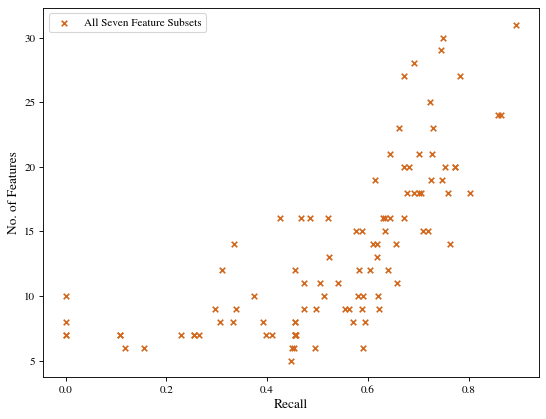

In [49]:
# # init_pop = genfromtxt('diverse_pop_ Recall_loglasso.csv', delimiter=',')
init_pop = make_initial_pop(pop_size)

#  Get all fronts of initial population
init_pop_eval = evaluation(init_pop)
init_fronts, init_fronts_indices = get_all_fronts(init_pop_eval, init_pop)

# Save or show a save of initial pop, save is zero, show is one
plot_initpop(init_pop_eval, show_or_save=1, lims=False)

## Main loop

In [56]:
def plot_PF(front, figure_title, show_or_save, lims=True):
    '''
    Plots all fronts, from every iteration
    '''
    # Plot best front from initial pop for comparison purposes
#     plt.scatter(init_fronts[0][:,1], init_fronts[0][:,0], color = 'cornflowerblue', s=45, marker="X", label="Init pop PF")
    plt.scatter(front[:,0], front[:,1], color = 'firebrick', s=45, marker="X")
    plt.plot(front[:,0], front[:,1], color = 'firebrick', label=f"FNSGA-II {num_iter} Iter PF")
            
    plt.scatter(results_MOPSO[:,0], results_MOPSO[:,1], color = 'fuchsia', s=45, marker="v")
    plt.plot(results_MOPSO[:,0], results_MOPSO[:,1], color = 'fuchsia', label=f"MOPSO 20 Iter PF", linestyle=(0, (3, 5, 1, 5)))
    
    plt.scatter(results_MODE[:,0], results_MODE[:,1], color = 'darkorange', s=45, marker="d")
    plt.plot(results_MODE[:,0], results_MODE[:,1], color = 'darkorange', label=f"MODE 20 Iter PF", linestyle='dotted')
    
    plt.scatter(results_SPEA2[:,0], results_SPEA2[:,1], color = 'forestgreen', s=45, marker="*")
    plt.plot(results_SPEA2[:,0], results_SPEA2[:,1], color = 'forestgreen', label=f"SPEA-II 20 Iter PF", linestyle='dashdot')
    
    plt.scatter(results_NSGA2[:,0], results_NSGA2[:,1], color = 'cornflowerblue', s=45, marker="^")
    plt.plot(results_NSGA2[:,0], results_NSGA2[:,1], color = 'cornflowerblue', label=f"NSGA-II 20 Iter PF", linestyle=(0, (1, 10)))
    
    if data_set != 'churn' and objective2 == 'num_features':
    
        paper_results = hfmoea_results[data_set]

        if data_set == 'congress' or data_set == 'sonar':
            plt.scatter(paper_results[1], paper_results[0], color = 'navy', s=45, marker="s", label=f"HFMOEA Paper",)

        else:
            plt.plot(paper_results[:,1], paper_results[:,0], color = 'navy', label=f"HFMOEA Paper", linestyle='--')
            plt.scatter(paper_results[:,1], paper_results[:,0], color = 'navy', s=45, marker="s")
    
    plt.xlabel(scoring_metric)
    plt.ylabel(y_axis_label)

    plt.legend(loc='upper left')
    
    if lims:
        plt.xlim(set_xlim[0],set_xlim[1])
        plt.ylim(set_ylim[0],set_ylim[1])
    
    if show_or_save == 0:

        plt.savefig(f"Graphs/{figure_title}.pdf", format="pdf", dpi=1200, bbox_inches='tight')

        plt.clf()
    
    if show_or_save == 1:
        plt.show()

In [51]:
# One loop of outer loop (one value of i) is a RUN
# One loop of inner loop (one value of j) is an ITERATION

localsearch_accepted = []

polygon_selection = 0

# For each new graph, store the best fronts in this array, for plotting
fronts_all_iter = []
fronts_all_iter.append(init_fronts[0])

# Keep running array of arrays of all populations (for looping)
every_iter_pop = []

every_iter_pop.append(init_pop)

# Do this many iterations of NSGA-II per graph
for j in range(num_iter):
    
    iters_remaining = num_iter - (j+1)
    # Use PS for user set amount of last iter 
    if (iters_remaining <= polyselect_last_n):
        
        polyselect_param = iters_remaining/1000
        polygon_selection = 1

    NSGA2_create_next_generation(every_iter_pop[j], config)

# Include the best Local Search evaluations in calculating the best front for the whole run
if polygon_selection == 1:
    
    if len(localsearch_accepted) > 1:

        fronts_all_iter.append(best_PF(localsearch_accepted))

non_dom_this_run = best_PF(fronts_all_iter)
# np.savetxt(f'FNSGA_{objective2}/{data_set}_FNSGA2.csv', non_dom_this_run, delimiter=",")

In [52]:
# Declaring results from other MOEAs 
if objective2 == 'num_features':
    path = 'Other_MOEAs'
else:
    path = 'Other_MOEAs_time'

results_MODE = genfromtxt(f'{path}/{data_set}_MODE.csv', delimiter=',')
results_MOPSO = genfromtxt(f'{path}/{data_set}_MOPSO.csv', delimiter=',')
results_SPEA2 = genfromtxt(f'{path}/{data_set}_SPEA2.csv', delimiter=',')
results_NSGA2 = genfromtxt(f'{path}/{data_set}_NSGA2.csv', delimiter=',')

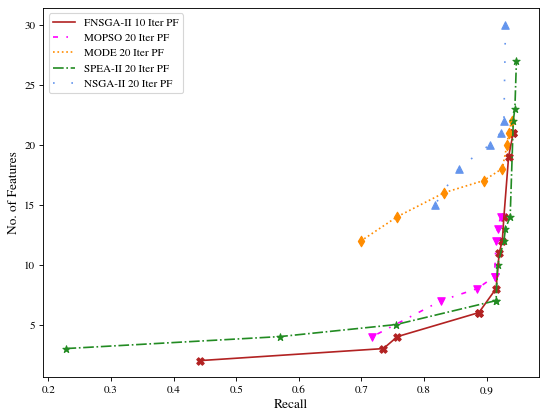

In [57]:
# Set consistent axis limits
set_xlim = (0.6,1)
set_ylim = (0,28)

plot_PF(non_dom_this_run, f'_{data_set}_{num_iter}_{objective2}', show_or_save=1, lims=False)

In [ ]:
X_train.shape

## Table of results for this run

In [ ]:
# Change index to the front of the graph you want to look at
front = non_dom_this_run
df = front_scores(front[:5], sortby = 'Recall')
display(df)

In [ ]:
# Use row index above to get the features that point trained on
get_names(front[4])

In [ ]:
latex_table = df.to_latex(index=False)
print(latex_table)

# -------------------------   Testing/Development Area   -------------------------

In [ ]:
# Saving a population 
np.savetxt("diverse_recall_45feats.csv", diverse_pop, delimiter=",")

## PS Visualiser Functions

In [ ]:
def display_polygons(fronts, neigh_ev_before, neigh_ev_after, polyselect_param, plot_polys, show_or_save):
    
    if len(fronts[0]) > 1:
        front = fronts[0]
        
    else:
        front = fronts[1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    if plot_polys:
    
        polygon, poly_patch = make_polygons(front[:,:2], polyselect_param)
            
        ax.add_patch(poly_patch)
        
#     plt.xlim(min(front[:,0])-0.008, max(front[:,0])+0.008)
#     plt.ylim(0, max(front[:,1])+0.05)

#     plt.xlim(set_xlim[0],set_xlim[1])
#     plt.ylim(set_ylim[0],set_ylim[1])

    plt.ylim(0,1)
                 
    if scoring_metric == 'Mixed':
        plt.xlabel('Avg. MC, Recall and F1 Scores')
        
    else:
        plt.xlabel(scoring_metric)
    
    plt.ylabel("Normalised Comp. Time")
    
                 
    plt.plot(front[:,0], front[:,1], c ='black', label="Pareto Front")
    plt.scatter(neigh_ev_before[:,0], neigh_ev_before[:,1], c ='firebrick', label="Rejected Solutions", marker="x", s=30)
    
    if neigh_ev_after.shape[0] != 0:
      
        plt.scatter(neigh_ev_after[:,0], neigh_ev_after[:,1], c = 'navy', label="Accepted Solutions", marker="s", s=30)
        
    plt.legend(loc='upper left')
    
    if show_or_save == 0:
        plt.savefig(f"Graphs/slice_{j}.pdf", format="pdf", dpi=1200, bbox_inches='tight')
        plt.clf()
        
    else:
        plt.show()

In [ ]:
polyselect_param = 0.003

pop = make_initial_pop(pop_size)
evaluated_pop = evaluation(pop)
fronts, fronts_indices = get_all_fronts(evaluated_pop, pop)
neigh_before =  neighbourhood_search(fronts, 4, front_points=6)
neigh_before_ev = evaluation(neigh_before)

neigh_after_ev, neigh_after = points_inside_area(fronts, neigh_before_ev)

display_polygons(fronts, neigh_before_ev, neigh_after_ev, polyselect_param, plot_polys=1, show_or_save=1)

## Polygon Selection Visualiser Functions

In [ ]:
def plot_neighbourhood(fronts, data, crossed, mutated, show_or_save):
    
    front = fronts[0]
    
    plt.plot(front[:,0], front[:,1], c ='black', label="Pareto Front")

    # Plot neighbourhood
    plt.scatter(data[:,0], data[:,1], c ='firebrick', label='Local Search', s=30, marker="+")
    
    plt.scatter(crossed[:,0], crossed[:,1], c ='cornflowerblue', label='Crossed LS', s=30, marker="+")

    plt.scatter(mutated[:,0], mutated[:,1], c ='darkgreen', label='Mutated LS', s=30, marker="+")

#     plt.xlim(min(front[:,0])-0.008, max(front[:,0])+0.008)
#     plt.ylim(0.225, max(front[:,1])+0.05)
    
#     plt.xlim(set_xlim[0],set_xlim[1])
#     plt.ylim(set_ylim[0],set_ylim[1])

    if scoring_metric == 'Mixed':
        plt.xlabel('Avg. MC, Recall and F1 Scores')
        
    else:
        plt.xlabel(scoring_metric)
    
    plt.ylabel("Normalised Comp. Time")
    plt.legend(loc='upper left')
    
    if show_or_save == 0:
        plt.savefig(f"Graphs/slice_{j}.pdf", format="pdf", dpi=1200, bbox_inches='tight')
        plt.clf()
        
    else:
        plt.show()

In [ ]:
# Initialise seeded population
pop = make_initial_pop(pop_size)
evaluated_pop = evaluation(pop)
fronts, fronts_indices = get_all_fronts(evaluated_pop, pop)
neigh_before =  neighbourhood_search(fronts, 4, front_points=6)
neigh_ev_before = evaluation(neigh_before)

neigh_ev_after, neigh_after = points_inside_area(fronts, neigh_ev_before)

crossed = crossover(1, cross_k_param, copy.deepcopy(neigh_after))
crossed_ev = evaluation(crossed)
mutated = mutation(crossed, 2)
mutated_ev = evaluation(mutated)
plot_neighbourhood(fronts, neigh_ev_before, crossed_ev, mutated_ev, show_or_save=1)

## Diverse population

In [ ]:
def find_max_distance_points(evaluated_pop, num_chosen_points):
    
    '''
    In order to get a diverse population, pick points that are the furthest apart
    This function returns the chromosomes of those points, to act as input into the NSGA-II
    '''
    
    points = evaluated_pop[:,:2]
    
    chosen_indices = [random.randint(0, len(points) - 1)]
    distances = distance_matrix(points, points)
    max_distances = distances[chosen_indices[0]]

    for _ in range(num_chosen_points - 1):
        new_point_idx = np.argmax(max_distances)
        chosen_indices.append(new_point_idx)

        # Update max_distances with the minimum distance to the newly added point
        max_distances = np.minimum(max_distances, distances[new_point_idx])
        
    return evaluated_pop[chosen_indices]

In [ ]:
# # # Make small pop for comparison
pop = make_initial_pop(100)

pop_ev = evaluation(pop)

# Make big pop
big_pop = make_initial_pop(10000)

big_pop_ev = evaluation(big_pop)

# Get 100 points of big pop that are furthest apart
chosen_chromosomes = find_max_distance_points(big_pop_ev, 100)

diverse_pop = chosen_chromosomes[:,3:].astype(int)

# plt.scatter(pop_ev[:,0],pop_ev[:,1], c = 'firebrick', s=10, marker='x', label='Regular')

# plt.scatter(chosen_chromosomes[:,0],chosen_chromosomes[:,1], c = 'darkgreen', s=10, marker='x', label='Diverse')

# if scoring_metric == 'Mixed':
#     plt.xlabel('Avg. MC, Recall and F1 Scores')

# else:
#     plt.xlabel(scoring_metric)
    
# plt.ylabel("Normalised Comp. Time")

# # plt.vlines(x = score_all_X, ymin = 0, ymax = 1, color = 'purple', label=f"{scoring_metric} Full X", linestyle='--', linewidth=0.5)


# plt.legend(loc='upper left')
# plt.ylim(0.1,0.8)
# plt.xlim(0.1,0.75)

# plt.savefig(f"Graphs/diversityisourstrength_3.pdf", format="pdf", dpi=1200, bbox_inches='tight')

# plt.show()


### This function can be used for plotting the difference

In [ ]:
def create_polygon_from_piecewise_linear(points1, points2):
    """
    Create a polygon from two sets of points representing two separate piecewise linear functions.

    Parameters:
        points1 (numpy array): Points of the first piecewise linear function with shape (N, 2), where N is the number of points.
        points2 (numpy array): Points of the second piecewise linear function with shape (M, 2), where M is the number of points.

    Returns:
        matplotlib.patches.Polygon: A Matplotlib patch representing the polygon.
    """
    
    # Shapely draws vertices in the order you supply point tuples
    # So you have to supply the points in a specific order
    points_in_order = []
    
    # Reverse points list2
    points2 = points2[points2[:, 0].argsort()]
    
    # Combine both sets of points into a single array
    for point in points1:
        
        # Copies used because of paranoia
        points_in_order.append(copy.deepcopy(point))
        
    
    for point in points2:
        points_in_order.append(copy.deepcopy(point))
    
    polygon = Polygon(tuple(points_in_order))

    # Create a Matplotlib patch representing the polygon
    poly_patch = patches.Polygon(points_in_order, linewidth=1, edgecolor='orange', facecolor=(0, 1, 0, 0.2), label='Improvement In PF, 15 Iter')

    return polygon.area, poly_patch

# Example usage:
# Replace the following points with your actual data as numpy arrays
points1 = init_fronts[0][:,:2]
points2 = non_dom_this_run[:,:2]

polygon_area, polygon_patch = create_polygon_from_piecewise_linear(points1, points2)

# Plot the polygon using Matplotlib
fig, ax = plt.subplots()
ax.add_patch(polygon_patch)

plt.scatter(points1[:,0],points1[:,1], color = 'cornflowerblue', s=45, marker='H', label='Init pop PF')
plt.scatter(points2[:,0],points2[:,1], color = 'hotpink', s=45, marker='H', label='30 Iter PF')


plt.xlabel('Normalised Comp. Time')
plt.ylabel(scoring_metric)
plt.legend(loc='upper left')
# plt.xlim(set_xlim[0],set_xlim[1])
# plt.ylim(set_ylim[0],set_ylim[1])
plt.savefig(f"Graphs/run_scoring.pdf", format="pdf", dpi=1200, bbox_inches='tight')



In [ ]:
polygon_area

## See which partitions features are drawn from as optimal solutions

In [ ]:
def get_feature_prop(front):
    
    for el in front:
    
        chrom = el[3:].astype(int)

        partitions = [best_features, good_features, worst_features]

        feature_indices = np.where(chrom == 1)[0]

        for i, feat_set in enumerate(partitions):

            for feature in feature_indices:

                if feature in feat_set:

                    counts[i] += 1

### Input a chromosome, get its scores

In [ ]:
chrom = np.asarray([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1])
chrom_scores(chrom, sortby=scoring_metric)